In [1]:
#import the key libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style; style.use('ggplot')
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sid
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [2]:
#load the training data 
train = pd.read_csv ("C:\\Users\\hp\\Desktop\\Reviving python\\Datasets\\train.csv")
train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [3]:
#load the testing data
test = pd.read_csv("C:\\Users\\hp\\Desktop\\Reviving python\\Datasets\\test.csv")
test.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [4]:
#check if both data sets have similar features
list(train) == list(test)

True

the output is true meaning they have similar features and they have been split to make our model testing easy :-)

In [5]:
#lets find out the shape
train.values.shape[0], test.values.shape[0], 

(161297, 53766)

In [6]:
#lets find the train/test ratio
train.values.shape[0]/test.values.shape[0]

2.999981400885318

In [7]:
#find out the number of unique disease conditions in the train and test datasets
train.condition.unique().size, test.condition.unique().size

(885, 709)

In [8]:
#find out the number of unique drugs in the train and test datasets
train.drugName.unique().size, test.drugName.unique().size

(3436, 2637)

# Analysis  of the 20 most common Conditions


In [9]:
conditions = train.condition.value_counts().sort_values(ascending = False)
conditions[:20]

Birth Control                28788
Depression                    9069
Pain                          6145
Anxiety                       5904
Acne                          5588
Bipolar Disorde               4224
Insomnia                      3673
Weight Loss                   3609
Obesity                       3568
ADHD                          3383
Diabetes, Type 2              2554
Emergency Contraception       2463
High Blood Pressure           2321
Vaginal Yeast Infection       2274
Abnormal Uterine Bleeding     2096
Bowel Preparation             1859
ibromyalgia                   1791
Smoking Cessation             1780
Migraine                      1694
Anxiety and Stress            1663
Name: condition, dtype: int64

INSIGHTS:
1. 6/20 of the most common diseases are a form of mental illness with depression taking the lead
2. Birthcontrol medz are some of the most sought after
3. NCDs including diabetes type 2, hypertension, and obesity are among the top 20
4. Acne and weight loss are in the top 10
5. Vaginal yeast infection is the only infectious condition in the top 20

In [10]:
#change the default matplotlib parameters
plt.rcParams['figure.figsize'] = [12,8]

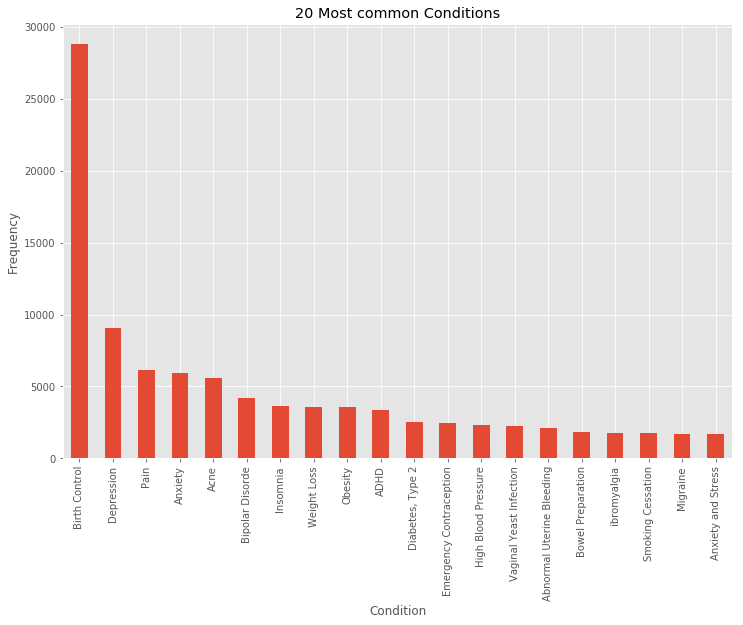

In [11]:
#visualize the 20 most common conditions
conditions[:20].plot(kind = 'bar')
plt.title('20 Most common Conditions')
plt.xlabel ('Condition')
plt.ylabel ('Frequency'); 

# Ratings Analysis


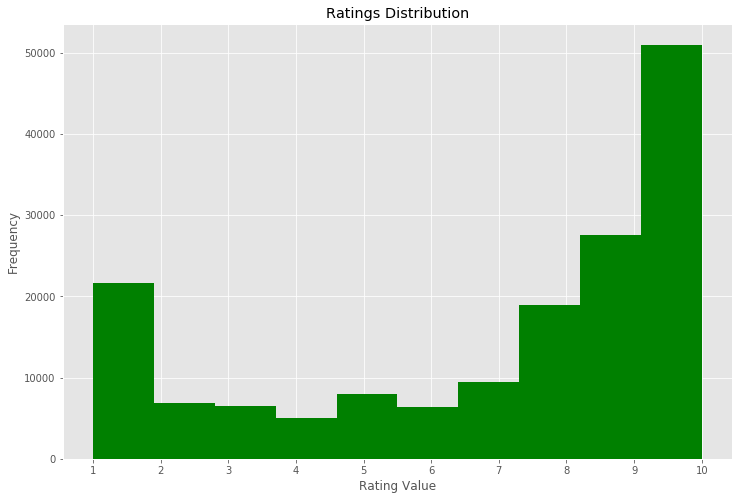

In [12]:
#check the ratings distribution. The patients rate the drugs from 0-10 so here we check the distribution of those ratings to see
#which ones are the most
train.rating.hist(color = 'green')
plt.title('Ratings Distribution')
plt.xlabel('Rating Value')
plt.ylabel('Frequency')
plt.xticks([i for i in range(1,11)]);

From the graph, its clear that the 10 rating which implies complete satisfaction has the most counts followed by 1 which implies great dissatifaction. This shows that clients hardly have mixed feelings about the products they use. Also most patients will review drugs they either like very much or those they dislike

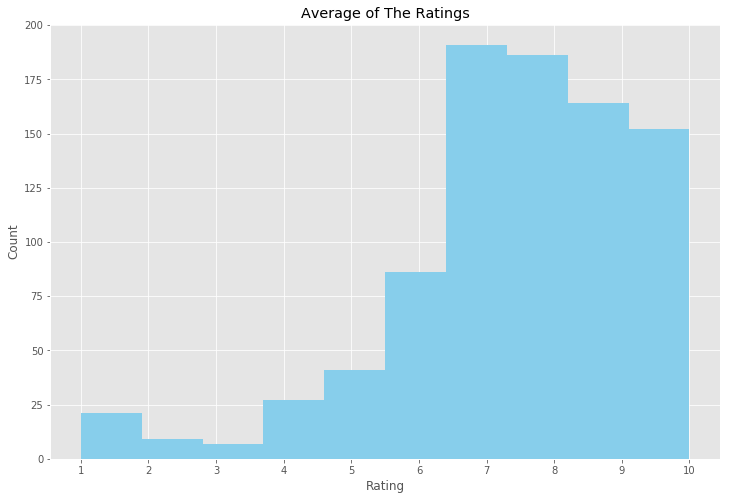

In [13]:
#AVERAGE OF THE RATINGS FOR THE CONDITIONS
ratings_avgs = (train['rating'].groupby(train['condition']).mean())
ratings_avgs.hist(color = 'skyblue')
plt.title('Average of The Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks([i for i in range(1,11)])
plt.show();


# Rating value vs. Usefullness of the Review

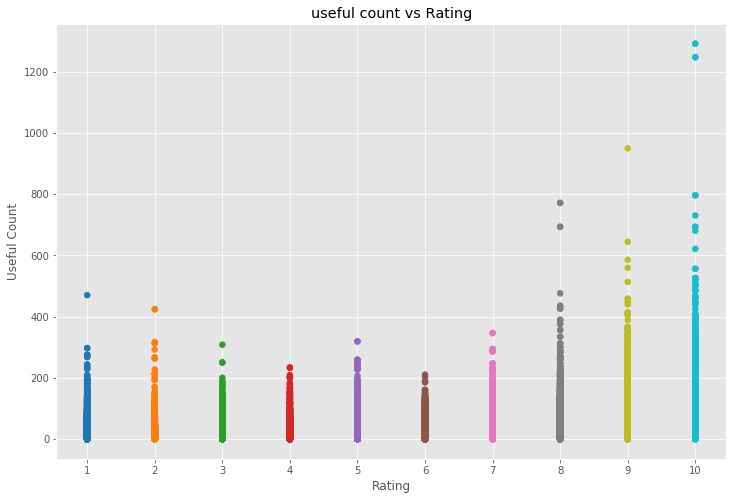

In [14]:
#this section seeks to find out if there is a correlation between the rating and the usefulness of the review to the next client.
#for instance, does a higher rating value mean more usefulness? 
plt.scatter(train.rating, train.usefulCount, c=train.rating.values,cmap ='tab10')
plt.title ('useful count vs Rating')
plt.xlabel('Rating')
plt.ylabel('Useful Count')
plt.xticks([i for i in range(1,11)]); 

Insight: 
There is a correlation between higher ratings and the usefulness of the review to the next user. This may imply that satisfied customers are more likely to give a more detailed description of the product compared to those who are not satisfied. 

In [15]:
#to ivestigate the correlation further, create a list of the average usefulness of the various ratings
#and cast it into an array
list = []
for i in range (1,11): 
    list.append([i, np.sum(train[train.rating == i].usefulCount) / np.sum([train.rating==i])])
array =np.asarray(list)
print (array)

[[ 1.         15.68846848]
 [ 2.         16.34295195]
 [ 3.         16.03592814]
 [ 4.         16.51157223]
 [ 5.         17.48071883]
 [ 6.         19.91092543]
 [ 7.         23.23392555]
 [ 8.         29.15590259]
 [ 9.         33.57778504]
 [10.         37.58045853]]


AttributeError: module 'matplotlib.pyplot' has no attribute 'xtics'

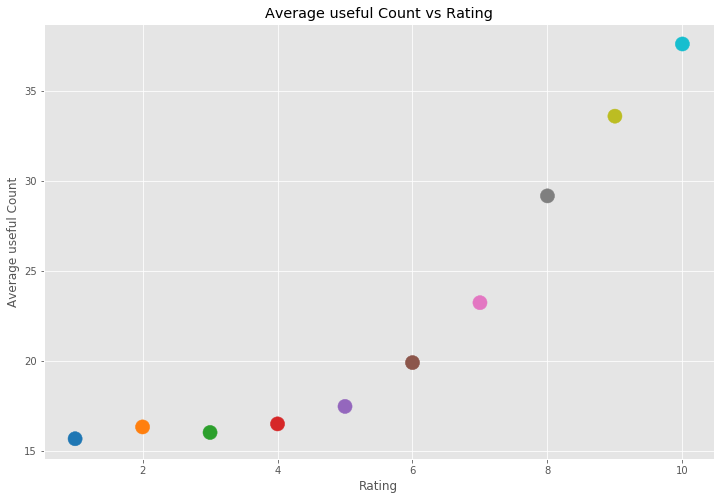

In [16]:
#visualize this averages
plt.scatter(array[:,0], array[:,1], c = array[:,0], cmap = 'tab10',s=200)
plt.title ('Average useful Count vs Rating')
plt.xlabel('Rating')
plt.ylabel('Average useful Count')
plt.xtics([i for i in range(1,11)]);

INSIGHT: It is therefore clear that higher ratings have reviews that are more useful to other patients. 

# So, What exactly makes a Review useful? 


In [ ]:
useful = train.sort_values(by = 'usefulCount', ascending = False)
useful.iloc [:10]

In [ ]:
#lets have a look at the five most useful reviews
for i in useful.review.iloc[:5]:
    print(i, '\n')

In [ ]:
#print out the five least useful reviews
for i in useful.review.iloc[-5:]:
    print(i, '\n')

INSIGHT: it is clear that the reviews considered useful sound positive and are higher rated while the least useful reviews are negative and rated low. 
There seems to be a bias on the reviewers who find only the positive reviews useful and not the negative ones. 

Would you not find the negative review of a product useful too? Well, lets keep exploring the data!

    # Lets check the 10 best and worst reviewed drugs

###### Create a list of all drugs and their average ratings, cast to dataframe
rate_ls = []

for i in train.drugName.unique():
    
    # Only consider drugs that have at least 10 ratings
    if np.sum(train.drugName == i) >= 10:
        rate_ls.append((i, np.sum(train[train.drugName == i].rating) / np.sum(train.drugName == i)))
    
avg_rate = pd.DataFrame(rate_ls)





In [ ]:
avg_rate = avg_rate.sort_values(by=[1], ascending=False).reset_index(drop=True)
avg_rate[:10]

In [ ]:
#ten worst drugs
avg_rate[-10:]

# Find the best and worst reviewed drugs according to conditions.

In [ ]:
#create a dictionary of conditions where each value will be a dataframe of all the drugs used to treat different conditions

drug_dict ={}

#create an interation over the conditions
for i in train.condition.unique():
    temp_ls = []
    
#iterate over drugs within a given condition
    for j in train[train.condition == i].drugName.unique():
        
        #if a drug has atleast 10 reviews, save its name and average rating in a temporary list
        if np.sum(train.drugName == j) >= 10:
            temp_ls.append((j, np.sum(train[train.drugName ==j].rating)/np.sum(train.drugName ==j)))
        
        #now save the temporary list as a dataframe as a value in the dictionary we created above and sort the drugs in descending order
drug_dict[i] = pd.DataFrame(data = temp_ls, columns = ['drug','average_rating']).sort_values(by = 'average_rating', acending =False).reset_index(drop =True) 

In [ ]:
#now using the drug_dict we created, we can use the disease conditions to index the top rated drugs
drug_dict['Birth Control'].iloc[:10]

# MACHINE LEARNING MODELS
 we will now fit the data into different machine learning models and see  which one is best. 
 Both regression and classification models will be applied. 
 
 SK LEARN AND RANDOM FRORESTS 
 random forests will be key for the sentiment analysis.
 The vectorization method will be used to convert raw test into numerical values that can be processed. 
 The TF -IDF method will be used. 
 

In [ ]:
#Create TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train.review)

#tranform test reviewa to the vectorized format above
X_test = vectorizer.transform(test.review)

# Naive Bayes
this is the simplest model we can attempt to fit on this data and since its scalable its a good first choice. We will first test it on a binarized version of the rating column to try identify which reviews are favourable, where a favourable rating is one above 5. 


In [ ]:
#create a column with binary rating indicating the polarity of a review
train['binary_rating'] = train['rating'] > 5

y_train_rating = train.binary_rating
clf = MultinomialNB().fit(X_train, y_train_rating)

#Evaluates model on test set
test['binary_rating'] = test.rating >5
y_test_rating = test.binary_rating
pred = clf.predict(X_test)

print("Accuracy: %s" % str(clf.score(X_test, y_test_rating)))
print("Confusion Matrix")
print(confusion_matrix(pred, y_test_rating))

# Random Forest Classifier


In [ ]:
#Train Random Forest Classifier
start = time.time()
rfc_rating = RandomForestClassifier(n_estimators = 100, random_state = 42, max_depth = 10000,
                                   min_samples_split = 0.001)
rfc_rating.fit(X_train,y_train_rating)
end = time.time()
print("Training time: %s" %str(end-start))

#Evaluate model on the test set
pred = rfc_rating.predict(X_test)

print("Accuracy: %s" % str(rfc_rating.score(X_test, y_test_rating)))
print("Confusion Matrix")
print(confusion_matrix(pred, y_test_rating))

A more complex model gives a higher accuracy

# Regression with SK learn


In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import stop_words

#lets import our data afresh to ensure accuracy since we have chnaged it alot along the way. 
train = pd.read_csv("C:\\Users\\hp\\Desktop\\Reviving python\\Datasets\\train.csv")
test = pd.read_csv("C:\\Users\\hp\\Desktop\\Reviving python\\Datasets\\test.csv")

#retrieve the review data and reshape
reviews = np.vstack((train.review.values.reshape(-1,1),test.review.values.reshape(-1,1)))

#Set up functions to re-vectorize values
vectorizer = CountVectorizer(binary=False, stop_words='english',
                             lowercase=True, min_df=3, max_df=0.9, max_features=500)

#vectorise the reviews
X = vectorizer.fit_transform(reviews.ravel()).toarray()

#get ratings
ratings = np.concatenate((train.rating.values, test.rating.values)).reshape(-1, 1)
             
y = ratings

X_train, X_test = X[:train.values.shape[0], :], X[train.values.shape[0]:, :] 
y_train, y_test = y[:train.values.shape[0]], y[train.values.shape[0]:]

In [ ]:
X.shape, y.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

# Linear Regression Model


In [ ]:
from sklearn. linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train[:5000], y_train[:5000])

In [ ]:
pred = lin_reg.predict(X_train[5000:])

In [ ]:
np.sum(np.abs(y_train[5000:] - pred[:])) / (161297 - 5000)

We end predicting the score of the review with only 2.3 error which is not bad based on all the experimentation we have had. 